In [148]:
%matplotlib inline

In [159]:
import sys

In [2]:
# Step 1: Install Kaggle CLI
!pip install kaggle --quiet

# Step 2: Set the name of the subfolder where you uploaded your kaggle.json
uploaded_folder = '.'  # <--- Change this if your subfolder has another name!

# Step 3: Move kaggle.json safely
import os
import shutil

# Paths
uploaded_kaggle_path = os.path.join(uploaded_folder, 'kaggle.json')
kaggle_dir = os.path.expanduser('~/.kaggle')
kaggle_json_target = os.path.join(kaggle_dir, 'kaggle.json')

# Create .kaggle directory if it doesn't exist
os.makedirs(kaggle_dir, exist_ok=True)

# Move (copy) the uploaded kaggle.json securely
if os.path.exists(uploaded_kaggle_path):
    shutil.copy(uploaded_kaggle_path, kaggle_json_target)  # Use copy to avoid cross-device issues
    os.chmod(kaggle_json_target, 0o600)
    print("✅ Kaggle API token copied and secured.")
else:
    raise FileNotFoundError(f"🚨 kaggle.json not found at {uploaded_kaggle_path}. Please check your upload.")

# Step 4: Download the dataset
dataset_dir = os.path.expanduser('~/datasets/rsna-pneumonia')
os.makedirs(dataset_dir, exist_ok=True)

print("⬇️ Downloading the dataset...")
!kaggle competitions download -c rsna-pneumonia-detection-challenge -p {dataset_dir}

print("✅ Download complete!")

# Step 5: Remove the Kaggle token immediately after download
try:
    os.remove(kaggle_json_target)
    print("🧹 Kaggle API token removed from server.")
except FileNotFoundError:
    print("⚠️ No kaggle.json found to remove — maybe already cleaned up.")



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


FileNotFoundError: 🚨 kaggle.json not found at ./kaggle.json. Please check your upload.

# step 5: unsip the downloaded file
import zipfile
import os

dataset_dir ='./datasets/rsna-pneumonia'
zip_path = os.path.join(dataset_dir, 'rsna-pneumonia-detection-challenge.zip')

if os.path.exists(zip_path):
    print("📦 Unzipping main rsna-pneumonia-detection-challenge.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("✅ Main archive extracted!")
else:
    print("🚨 No zip file found!")

In [ ]:
# Step 7: Unzip all zip-files
import zipfile
import glob

dataset_dir = './datasets/rsna-pneumonia/'

# Find all .zip files
zip_files = glob.glob(os.path.join(dataset_dir, '*.zip'))

# Unzip each one
for zip_path in zip_files:
    print(f"Unzipping {os.path.basename(zip_path)}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print(f"✅ {os.path.basename(zip_path)} extracted.")

print("🎉 All ZIP files have been extracted.")

In [5]:
import pandas as pd
import os

# Set the path to the labels file
dataset_dir = './datasets/rsna-pneumonia'  # Your corrected dataset path
labels_path = os.path.join(dataset_dir, 'stage_2_train_labels.csv')

# Load the CSV into a DataFrame
df_labels = pd.read_csv(labels_path)

# Show basic info
print("✅ Labels loaded successfully!")
print(df_labels.head())



✅ Labels loaded successfully!
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [6]:
# Paths
dataset_dir = './datasets/rsna-pneumonia'
images_dir = os.path.join(dataset_dir, 'stage_2_train_images')  # folder where DICOM images are
labels_path = os.path.join(dataset_dir, 'stage_2_train_labels.csv')

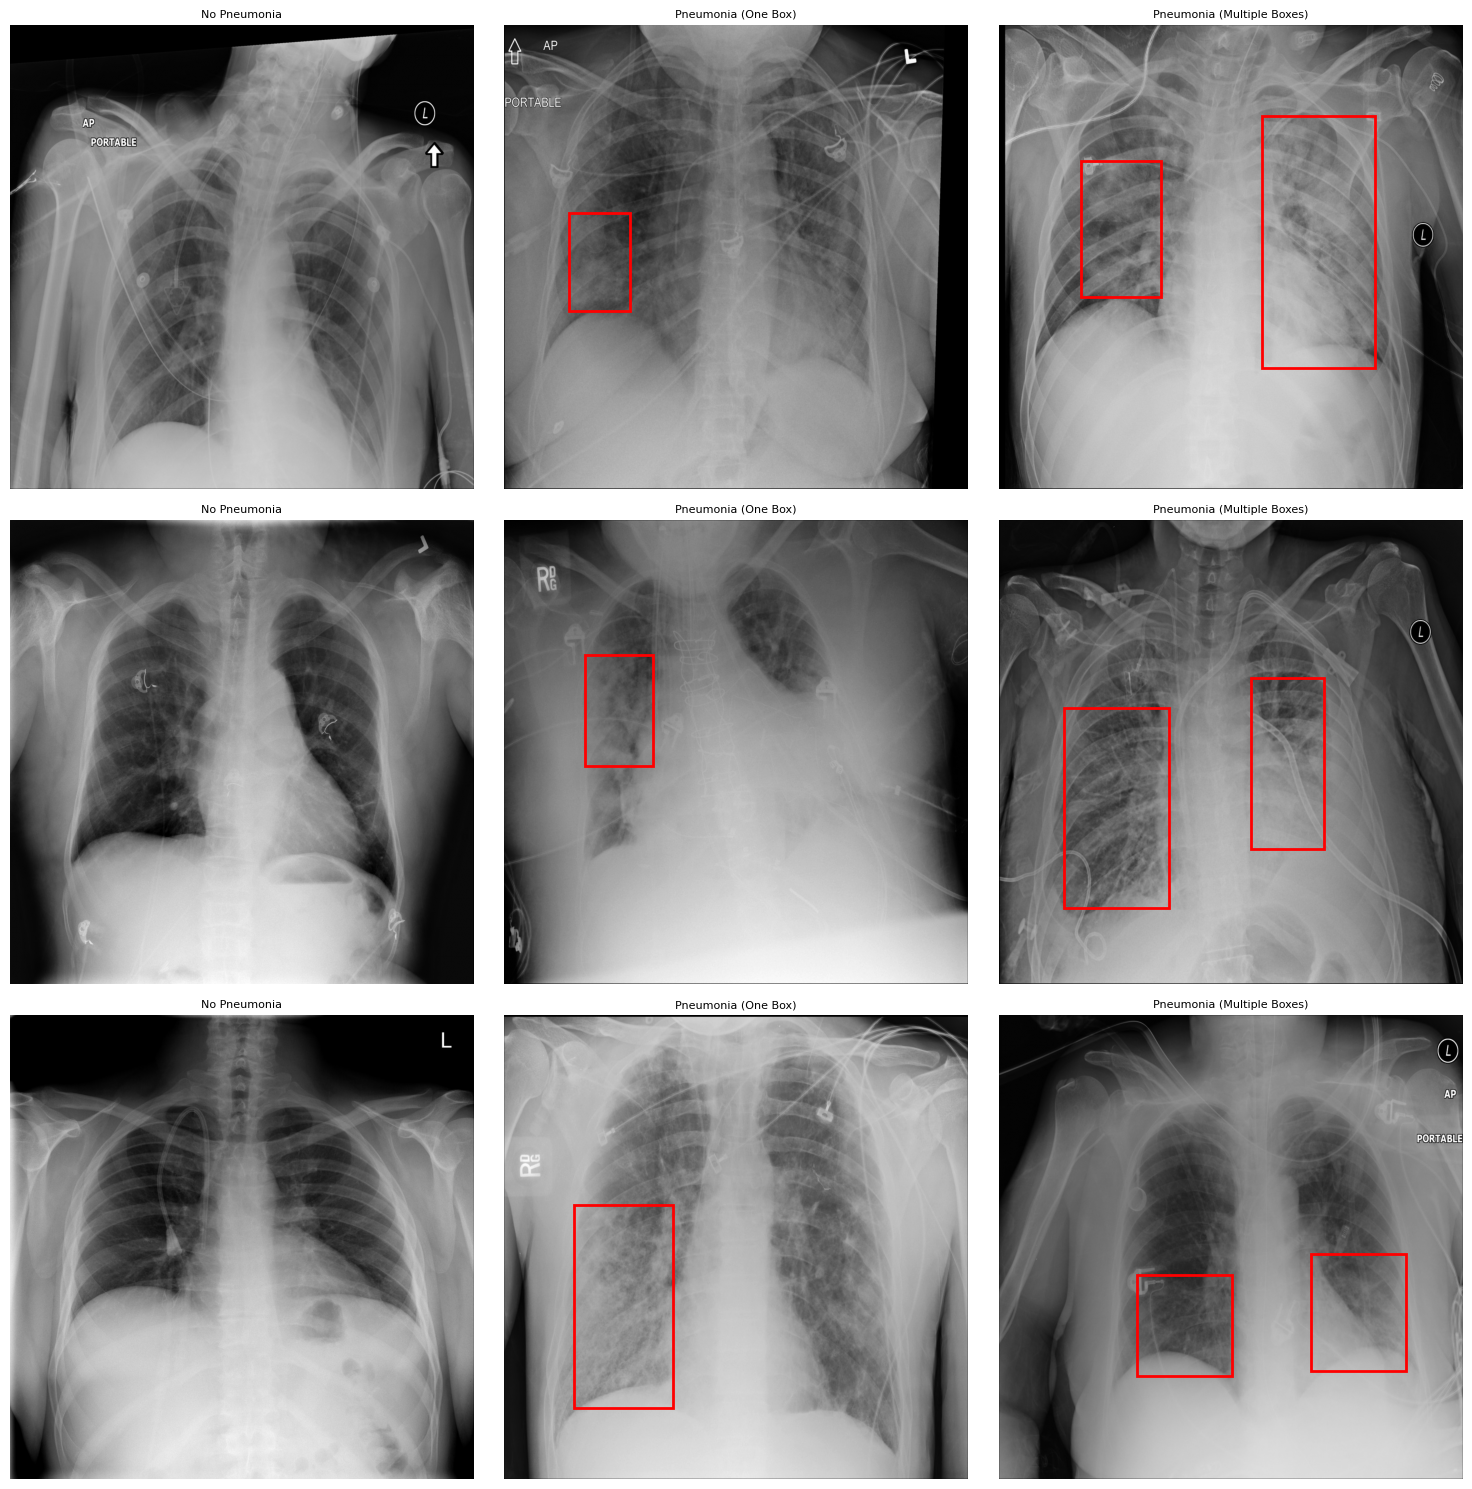

In [8]:

# Prepare categories
no_pneumonia_patients = df_labels[df_labels['Target'] == 0]['patientId'].unique()

# Pneumonia cases
pneumonia_cases = df_labels[df_labels['Target'] == 1]

# Patients with exactly one bbox
one_bbox_patients = (pneumonia_cases
                     .groupby('patientId')
                     .size()
                     .reset_index(name='n_bboxes'))
one_bbox_patients = one_bbox_patients[one_bbox_patients['n_bboxes'] == 1]['patientId'].values

# Patients with multiple bboxes
multi_bbox_patients = (pneumonia_cases
                       .groupby('patientId')
                       .size()
                       .reset_index(name='n_bboxes'))
multi_bbox_patients = multi_bbox_patients[multi_bbox_patients['n_bboxes'] > 1]['patientId'].values

# Helper function to get bounding boxes for a patient
def get_bboxes(patient_id):
    return pneumonia_cases[pneumonia_cases['patientId'] == patient_id][['x', 'y', 'width', 'height']].values

# Helper function to plot a patient
def plot_patient(ax, patient_id, title):
    dcm_path = os.path.join(images_dir, f"{patient_id}.dcm")
    dcm_data = pydicom.dcmread(dcm_path)
    image = dcm_data.pixel_array
    ax.imshow(image, cmap='gray')
    
    # Plot bounding boxes if pneumonia
    patient_labels = df_labels[df_labels['patientId'] == patient_id]
    if patient_labels['Target'].any():  # if any Target == 1
        bboxes = get_bboxes(patient_id)
        for (x, y, w, h) in bboxes:
            rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(rect)
    
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# Plotting 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row in range(3):
    # Select one random patient from each category
    no_pneu_patient = pd.Series(no_pneumonia_patients).sample(1).values[0]
    one_bbox_patient = pd.Series(one_bbox_patients).sample(1).values[0]
    multi_bbox_patient = pd.Series(multi_bbox_patients).sample(1).values[0]
    
    # Plot in the corresponding columns
    plot_patient(axes[row, 0], no_pneu_patient, "No Pneumonia")
    plot_patient(axes[row, 1], one_bbox_patient, "Pneumonia (One Box)")
    plot_patient(axes[row, 2], multi_bbox_patient, "Pneumonia (Multiple Boxes)")

plt.tight_layout()
plt.show()

In [9]:
df_labels[df_labels['Target']==1].head()

patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1

In [10]:
multi_bbox_patients = (pneumonia_cases
                       .groupby('patientId')
                       .size()
                       .reset_index(name='n_bboxes'))
print(type(multi_bbox_patients))
single_bbox_patients = multi_bbox_patients[multi_bbox_patients['n_bboxes'] ==1]['patientId'].values
multi_bbox_patients = multi_bbox_patients[multi_bbox_patients['n_bboxes'] > 1]['patientId'].values
print(multi_bbox_patients[:10])
print(f'Pneumonia patients with more than one box: {multi_bbox_patients.shape[0]}')


print(f'Pneumonia patients with one box: {single_bbox_patients.shape[0]}')

<class 'pandas.core.frame.DataFrame'>
['000db696-cf54-4385-b10b-6b16fbb3f985'
 '000fe35a-2649-43d4-b027-e67796d412e0'
 '001031d9-f904-4a23-b3e5-2c088acd19c6'
 '0022073f-cec8-42ec-ab5f-bc2314649235'
 '002cb550-2e31-42f1-a29d-fbc279977e71'
 '00436515-870c-4b36-a041-de91049b9ab4'
 '00704310-78a8-4b38-8475-49f4573b2dbb'
 '0087bd3a-55a7-4045-b111-b018fa52d361'
 '00a05408-8291-4231-886e-13763e103161'
 '00aecb01-a116-45a2-956c-08d2fa55433f']
Pneumonia patients with more than one box: 3398
Pneumonia patients with one box: 2614


In [253]:
# ================================
# Pneumonia Detection - Starter
# ================================

# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# 📂 Paths
DATASET_DIR = './datasets/rsna-pneumonia'
IMAGES_DIR = os.path.join(DATASET_DIR, 'stage_2_train_images')
LABELS_PATH = os.path.join(DATASET_DIR, 'stage_2_train_labels.csv')



# ================================
# 🧠 Dataset Setup
# ================================

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import pydicom
import numpy as np
import os
import torchxrayvision as xrv

class PneumoniaDataset(Dataset):
    def __init__(self, labels_df, images_dir, transform=None, apply_lung_mask=False, contrast_enhance=False, masked = True):
        self.labels_df = labels_df
        self.images_dir = images_dir
        self.apply_lung_mask = apply_lung_mask
        self.contrast_enhance = contrast_enhance
        self.masked = masked
        # Default transform if none provided
        if transform is None:
            self.transform = T.Compose([
                xrv.datasets.XRayCenterCrop(),
                xrv.datasets.XRayResizer(512)
            ])
        else:
            self.transform = transform

        # Load lung segmentation model
        if self.apply_lung_mask:
            self.lung_segmenter = xrv.baseline_models.chestx_det.PSPNet()
            self.lung_segmenter.eval()
            for param in self.lung_segmenter.parameters():
                param.requires_grad = False

    def enhance_contrast(self, img, low_percentile=2, high_percentile=98):
        """Enhance contrast of the image for better lung segmentation."""
        p_low = np.percentile(img, low_percentile)
        p_high = np.percentile(img, high_percentile)
        img = (img - p_low) / (p_high - p_low)
        img = np.clip(img, 0, 1)
        img = img * 2048 - 1024
        return img

    def __len__(self):
        return len(self.labels_df['patientId'].unique())

    def __getitem__(self, idx):
        patient_id = self.labels_df['patientId'].unique()[idx]
        if self.masked:
             dcm_path = os.path.join(self.images_dir, f"{patient_id}_masked.dcm")
        else:  
            dcm_path = os.path.join(self.images_dir, f"{patient_id}.dcm")
        
        # Load and prepare image
        dcm_data = pydicom.dcmread(dcm_path)
        img = dcm_data.pixel_array.astype(np.float32)
        img = np.clip(img, -1024, 1024)
        
        # Add channel dimension if missing
        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)  # [1, H, W]
        
        # Save original
        img_original = img.copy()
        
        # --- FIX: Convert to Torch tensor before transforms ---
        img = torch.from_numpy(img).float()
        img_original = torch.from_numpy(img_original).float()
        
        # Apply transforms
        img = self.transform(img)
        img_original = self.transform(img_original)
        
        # Now proceed as before
        img_tensor = img  # already tensor
        img_original_tensor = img_original

        if self.apply_lung_mask:
            # Optionally enhance contrast before feeding into PSPNet
            if self.contrast_enhance:
                img_for_masking = self.enhance_contrast(img_original)
            else:
                img_for_masking = img_original

            img_for_masking = torch.tensor(img_for_masking)
            img_for_masking = img_for_masking.unsqueeze(0)  # batch dimension

            with torch.no_grad():
                seg_outputs = self.lung_segmenter(img_for_masking)
                seg_outputs = torch.sigmoid(seg_outputs)

                right_lung = seg_outputs[0, 5, :, :]
                left_lung = seg_outputs[0, 4, :, :]
                lung_mask = (right_lung + left_lung).clamp(0, 1)

                # Optional soft threshold if you want
                lung_mask = (lung_mask > 0.05).float()

            # Apply lung mask to original image
            img_tensor = img_original_tensor * lung_mask.unsqueeze(0)

        # Normalize for classifier
        img_tensor = (img_tensor + 1024) / 2048  # Bring to [0,1]
        img_tensor = torch.clamp(img_tensor, 0, 1)

        # Get label
        label = self.labels_df[self.labels_df['patientId'] == patient_id]['Target'].max()

        return img_tensor, label

# ================================
# 🔥 Model Setup
# ================================

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ================================
# 🚀 Train/Test Functions
# ================================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for images, labels in tqdm(loader, desc="Training Batches"):
        
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    return running_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total



In [277]:
from sklearn.model_selection import train_test_split

# Load full labels
#df_labels = pd.read_csv(LABELS_PATH)

# Unique patients
patient_ids = df_labels['patientId'].unique()

# Train/val split
train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

# Create datasets
train_df = df_labels[df_labels['patientId'].isin(train_ids)]
val_df = df_labels[df_labels['patientId'].isin(val_ids)]

In [13]:
import torchvision.transforms as transforms
BATCH_SIZE = 4
resize_transform = transforms.Compose([
                   transforms.Resize((512,512)),  # ResNet is usually trained on 224x224
])

train_dataset = PneumoniaDataset(train_df, IMAGES_DIR, transform = resize_transform,apply_lung_mask= False )
val_dataset = PneumoniaDataset(val_df, IMAGES_DIR, transform = resize_transform, apply_lung_mask=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

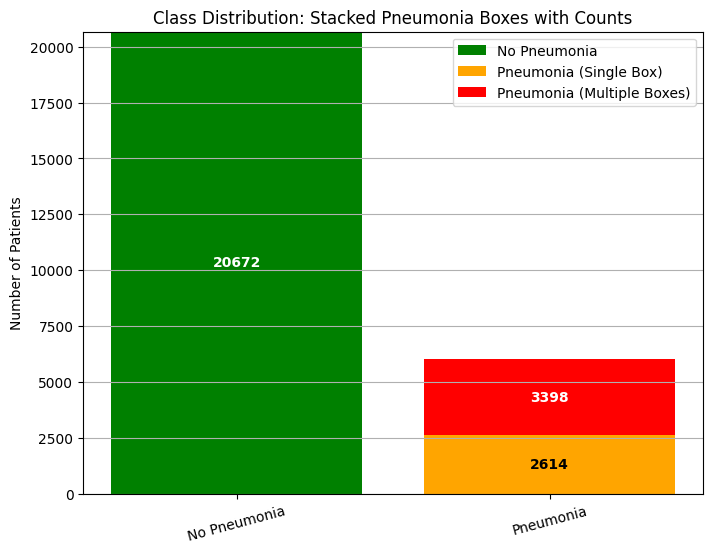

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load labels
df_labels = pd.read_csv(LABELS_PATH)

# Unique patient IDs
patient_ids = df_labels['patientId'].unique()

# Separate pneumonia cases
pneumonia_cases = df_labels[df_labels['Target'] == 1]
no_pneumonia_patients = df_labels[df_labels['Target'] == 0]['patientId'].unique()

# Count number of boxes per pneumonia patient
bbox_counts = pneumonia_cases.groupby('patientId').size()

# Initialize counters
no_pneumonia_count = len(no_pneumonia_patients)
single_box_count = 0
multi_box_count = 0

# Count patients with 1 vs multiple pneumonia boxes
for pid, count in bbox_counts.items():
    if count == 1:
        single_box_count += 1
    else:
        multi_box_count += 1

# Set up data for stacked bar
categories = ['No Pneumonia', 'Pneumonia']
no_pneu = [no_pneumonia_count, 0]
single_box = [0, single_box_count]
multi_box = [0, multi_box_count]

# Prepare bottom arrays
single_plus_no = np.array(no_pneu) + np.array(single_box)

# Plot
plt.figure(figsize=(8,6))

# First bar
plt.bar(categories, no_pneu, label='No Pneumonia', color='green')

# Stack single box
plt.bar(categories, single_box, bottom=no_pneu, label='Pneumonia (Single Box)', color='orange')

# Stack multi box
plt.bar(categories, multi_box, bottom=single_plus_no, label='Pneumonia (Multiple Boxes)', color='red')

# Add text labels
for idx, val in enumerate(no_pneu):
    if val > 0:
        plt.text(idx, val/2, str(val), ha='center', va='center', color='white', fontweight='bold')

for idx, val in enumerate(single_box):
    if val > 0:
        plt.text(idx, no_pneu[idx] + val/2, str(val), ha='center', va='center', color='black', fontweight='bold')

for idx, val in enumerate(multi_box):
    if val > 0:
        plt.text(idx, single_plus_no[idx] + val/2, str(val), ha='center', va='center', color='white', fontweight='bold')

# Labels and title
plt.ylabel('Number of Patients')
plt.title('Class Distribution: Stacked Pneumonia Boxes with Counts')
plt.xticks(rotation=15)
plt.legend()
plt.grid(axis='y')

plt.show()


In [241]:
def print_dicom_tags(dicom_path):
    """Print all available tags and their values in a DICOM file."""
    dcm = pydicom.dcmread(dicom_path)
    
    print(f"--- DICOM tags for: {dicom_path} ---")
    for elem in dcm.iterall():
        tag = elem.tag
        name = elem.name
        vr = elem.VR  # Value Representation (type of the field, like 'LO', 'CS', 'DA', etc.)
        value = elem.value

        if elem.value not in [None, '', [], b'']:
            print(f"{elem.tag} {elem.name} -- Has Value")
        else:
            print(f"{elem.tag} {elem.name} -- EMPTY")
    for elem in dcm.iterall():
        if elem.tag.is_private:
            print(f"Private tag: {elem.tag} - {elem.name}")

# Example usage:
print_dicom_tags("datasets/rsna-pneumonia/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm")

--- DICOM tags for: datasets/rsna-pneumonia/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm ---
(0008,0005) Specific Character Set -- Has Value
(0008,0016) SOP Class UID -- Has Value
(0008,0018) SOP Instance UID -- Has Value
(0008,0020) Study Date -- Has Value
(0008,0030) Study Time -- Has Value
(0008,0050) Accession Number -- EMPTY
(0008,0060) Modality -- Has Value
(0008,0064) Conversion Type -- Has Value
(0008,0090) Referring Physician's Name -- EMPTY
(0008,103E) Series Description -- Has Value
(0010,0010) Patient's Name -- Has Value
(0010,0020) Patient ID -- Has Value
(0010,0030) Patient's Birth Date -- EMPTY
(0010,0040) Patient's Sex -- Has Value
(0010,1010) Patient's Age -- Has Value
(0018,0015) Body Part Examined -- Has Value
(0018,5101) View Position -- Has Value
(0020,000D) Study Instance UID -- Has Value
(0020,000E) Series Instance UID -- Has Value
(0020,0010) Study ID -- EMPTY
(0020,0011) Series Number -- Has Value
(0020,0013) Instance Number -- Has Value
(0020,

In [220]:
 # Model
  
def simple_model_func(device):
    # Model
    model = models.resnet18(pretrained=False)  # pretrained=True if you want ImageNet weights
    
    # Modify final layer (originally for 1000 classes ➔ we want 1 output for binary classification)
    num_features = model.fc.in_features
    
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1),
        #nn.Sigmoid()  # (or no sigmoid if you plan to use BCEWithLogitsLoss)
    )
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    model = model.to(device)
    return model

In [215]:
import torchvision.models as models
# ================================
# 🎯 Main Training Loop
# ================================

def main(train_loader, val_loader, model = None):
    # Settings
    
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-3
    train_loader = train_loader
    val_loader = val_loader
    # add weight to loss as there is a class-imbalance, more non-pneumonia than pneumonia cases
    pos_weight = torch.tensor([no_pneumonia_count / (single_box_count + multi_box_count)])
   

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if model is None:
        model = simple_model(device)
    else:
        model = model.to(device)
    
    '''
    # Load data
    df_labels = pd.read_csv(LABELS_PATH)
    dataset = PneumoniaDataset(df_labels, IMAGES_DIR)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.0]).to(device))

    # Scheduler: reduce LR by half every 2 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_acc = evaluate(model, train_loader, device)
        val_acc = evaluate(model, val_loader, device)
        scheduler.step()
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), "simple_pneumonia_detector_masked.pth")
    print("✅ Model saved as simple_pneumonia_detector.pth")

#if __name__ == "__main__":
#    main()

In [ ]:
!nvidia-smi

In [ ]:
import torch
torch.cuda.empty_cache()


In [24]:
import torch

def show_gpu_memory():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)  # in MB
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)    # in MB
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved:  {reserved:.2f} MB")
    else:
        print("No GPU available.")

# Call it like this:
show_gpu_memory()


GPU Memory Allocated: 58.92 MB
GPU Memory Reserved:  802.00 MB


In [27]:
if torch.cuda.is_available():
       device = torch.device('cuda')

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

In [40]:
def test_model(model, loader, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Batches"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).view(-1)
            probs = outputs.cpu().numpy()
            labels = labels.cpu().numpy()

            all_probs.extend(probs)
            all_labels.extend(labels)
        print(all_probs[:10])
    return np.array(all_labels), np.array(all_probs)

In [43]:
def evaluate_predictions(y_true, y_probs, threshold=0.5):
    # Apply threshold
    y_pred = (y_probs > threshold).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report (precision, recall, f1-score)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pneumonia', 'Pneumonia'], yticklabels=['No Pneumonia', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Threshold sweep (Optional Cool Part)
    plot_threshold_vs_metrics(y_true, y_probs)

def plot_threshold_vs_metrics(y_true, y_probs):
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []

    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()

def plot_sensitivity_specificity_curve(y_true, y_probs):
    thresholds = np.linspace(0, 1, 100)
    sensitivities = []
    specificities = []
    youdens = []

    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        if cm.shape == (2,2):
            tn, fp, fn, tp = cm.ravel()

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            sensitivities.append(sensitivity)
            specificities.append(specificity)
            youdens.append(sensitivity + specificity - 1)
        else:
            sensitivities.append(0)
            specificities.append(0)
            youdens.append(-1)  # bad index if confusion matrix isn't 2x2

    sensitivities = np.array(sensitivities)
    specificities = np.array(specificities)
    youdens = np.array(youdens)

    # Find best threshold
    best_idx = np.argmax(youdens)
    best_sensitivity = sensitivities[best_idx]
    best_specificity = specificities[best_idx]
    best_threshold = thresholds[best_idx]

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(specificities, sensitivities, marker='o', label='Sensitivity vs Specificity Curve')
    plt.scatter(best_specificity, best_sensitivity, color='red', s=100, label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity vs Specificity Curve with Best Point')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"✅ Best Threshold: {best_threshold:.3f}")
    print(f"Sensitivity at best threshold: {best_sensitivity:.3f}")
    print(f"Specificity at best threshold: {best_specificity:.3f}")

def plot_sensitivity_specificity_vs_threshold(y_true, y_probs):
    thresholds = np.linspace(0, 1, 100)
    sensitivities = []
    specificities = []

    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        if cm.shape == (2,2):
            tn, fp, fn, tp = cm.ravel()

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            sensitivities.append(sensitivity)
            specificities.append(specificity)
        else:
            sensitivities.append(0)
            specificities.append(0)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, sensitivities, label='Sensitivity', color='blue')
    plt.plot(thresholds, specificities, label='Specificity', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Metric')
    plt.title('Sensitivity and Specificity vs Threshold')
    plt.grid()
    plt.legend()
    plt.show()

In [34]:
simple_model =  simple_model(device)
simple_model.load_state_dict(torch.load("simple_pneumonia_detector.pth", weights_only = True))


<All keys matched successfully>

In [288]:
def visuaize_metrics(model, loader, device):

    # After training is done
    y_true, y_probs = test_model(model, loader, device)
    y_probs = torch.sigmoid(torch.tensor(y_probs)).numpy()
    evaluate_predictions(y_true, y_probs)
    
    plot_sensitivity_specificity_curve(y_true, y_probs)

    plot_sensitivity_specificity_vs_threshold(y_true, y_probs)

    return y_true, y_probs

Testing Batches: 100%|██████████| 1335/1335 [01:31<00:00, 14.62it/s]


[np.float32(-2.3299773), np.float32(-0.8238102), np.float32(-0.0116223), np.float32(-1.6006473), np.float32(-1.191276), np.float32(1.0934559), np.float32(0.20175603), np.float32(-0.21370417), np.float32(0.7884544), np.float32(-0.21159562)]
Confusion Matrix:
[[2869 1239]
 [ 218 1011]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9294    0.6984    0.7975      4108
           1     0.4493    0.8226    0.5812      1229

    accuracy                         0.7270      5337
   macro avg     0.6894    0.7605    0.6893      5337
weighted avg     0.8188    0.7270    0.7477      5337



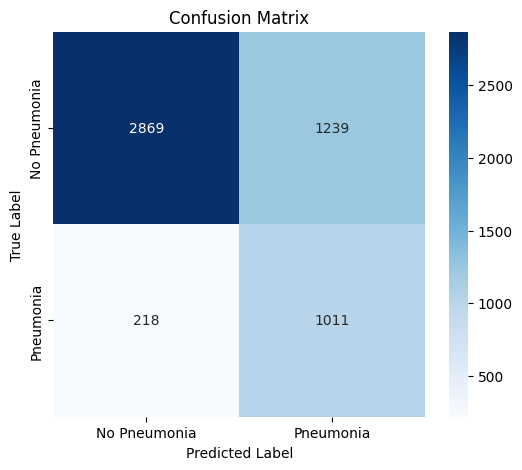

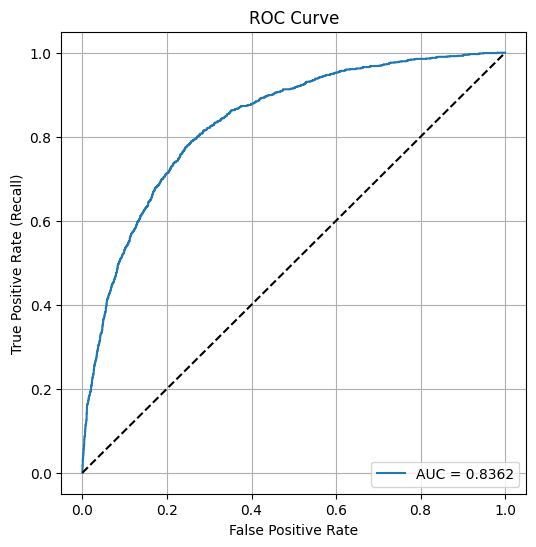

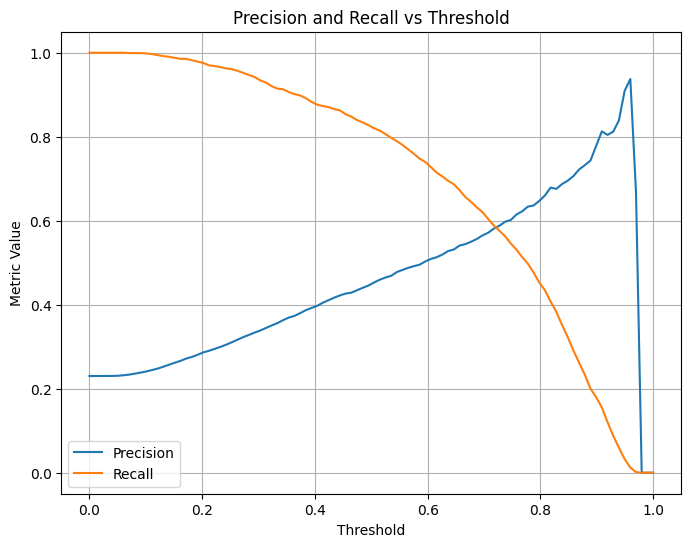

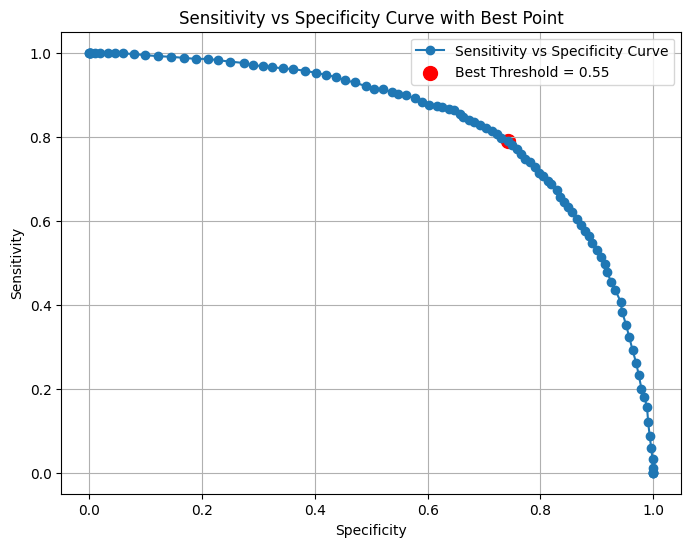

✅ Best Threshold: 0.545
Sensitivity at best threshold: 0.789
Specificity at best threshold: 0.742


In [289]:
y_t1, y_p1 = visualize_metrics(simple_model, val_loader, device)


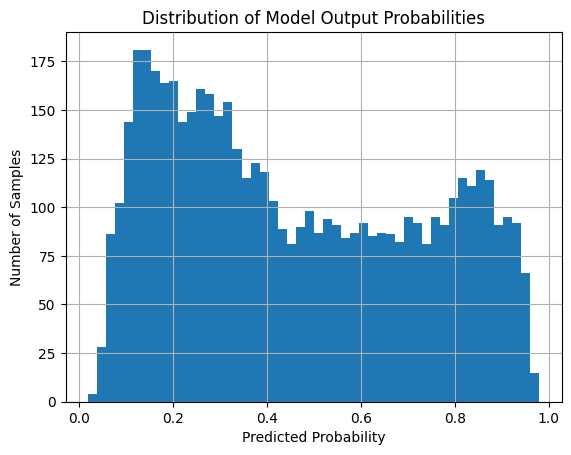

In [47]:
import matplotlib.pyplot as plt

plt.hist(y_probs, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Samples")
plt.title("Distribution of Model Output Probabilities")
plt.grid()
plt.show()

In [50]:
!pip install captum
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [93]:
import matplotlib
def apply_gradcam(model, image_tensor, target_layer, device):
    model.eval()
    
    # Forward pass
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    output = model(image_tensor)
    
    # Get prediction
    pred = torch.sigmoid(output).item()
    
    # GradCAM setup
    gradcam = LayerGradCam(model, target_layer)

    # Attribute for class 1 (pneumonia)
    attr = gradcam.attribute(image_tensor, target=0)  # binary classification
    attr = attr.squeeze().cpu().detach().numpy()
    
    return attr, pred


def show_gradcam_on_image(image_tensor, heatmap, title="Grad-CAM", cutoff_percent=0.7):
    import torch.nn.functional as F
    import torch

    # Prepare grayscale image
    image_np = image_tensor.squeeze().cpu().numpy()  # (H, W)
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

    # Normalize heatmap to [0,1]
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Upsample heatmap to match image size
    H, W = image_np.shape
    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    upsampled_heatmap = F.interpolate(heatmap_tensor, size=(H, W), mode='bilinear', align_corners=False)
    upsampled_heatmap = upsampled_heatmap.squeeze().numpy()

    # Apply cutoff
    masked_heatmap = np.copy(upsampled_heatmap)
    masked_heatmap[masked_heatmap < cutoff_percent] = np.nan

    # Create orange colormap
    base_cmap = plt.cm.Oranges
    base_cmap = base_cmap(np.arange(base_cmap.N))
    base_cmap[:, -1] = np.linspace(0, 1, base_cmap.shape[0])
    transparent_cmap = matplotlib.colors.ListedColormap(base_cmap)

    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(image_np, cmap='gray', vmin=0, vmax=1)  # Base image
    heatmap_img = ax.imshow(masked_heatmap, cmap=transparent_cmap)
    fig.colorbar(heatmap_img, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    ax.axis('off')
    plt.show()

In [53]:
import numpy as np

def pick_interesting_cases(y_true, y_probs, threshold=0.5, num_cases=3):
    """
    Pick top N true positives and false positives for visualization.
    
    Args:
        y_true (np.array): True binary labels (0 or 1)
        y_probs (np.array): Predicted probabilities (after sigmoid!)
        threshold (float): Decision threshold (default 0.5)
        num_cases (int): How many examples to pick for each
    
    Returns:
        true_positive_indices, false_positive_indices
    """
    # Apply threshold to get predicted labels
    y_pred = (y_probs > threshold).astype(int)

    # Find true positives (correctly predicted pneumonia)
    true_positives = np.where((y_true == 1) & (y_pred == 1))[0]

    # Find false positives (predicted pneumonia but actually healthy)
    false_positives = np.where((y_true == 0) & (y_pred == 1))[0]

    # Shuffle to randomize and pick a few
    np.random.shuffle(true_positives)
    np.random.shuffle(false_positives)

    true_positive_indices = true_positives[:num_cases]
    false_positive_indices = false_positives[:num_cases]

    return true_positive_indices, false_positive_indices


In [293]:
def attention_visualization(model, val_dataset, y_true, y_probs, device):
    tp_indices, fp_indices = pick_interesting_cases(y_true, y_probs, threshold=0.5, num_cases=3)
    target_layer = simple_model.layer4[-1]
    # Example: pick one TP
    image_tensor_tp, _ = val_dataset[tp_indices[0]]
    attr_tp, pred_tp = apply_gradcam(simple_model, image_tensor_tp, target_layer, device)
    show_gradcam_on_image(image_tensor_tp, attr_tp, title=f"True Positive - Prediction: {pred_tp:.2f}")
    
    # Example: pick one 
    image_tensor_fp, _ = val_dataset[fp_indices[0]]
    attr_fp, pred_fp = apply_gradcam(simple_model, image_tensor_fp, target_layer, device)
    show_gradcam_on_image(image_tensor_fp, attr_fp, title=f"False Positive - Prediction: {pred_fp:.2f}")

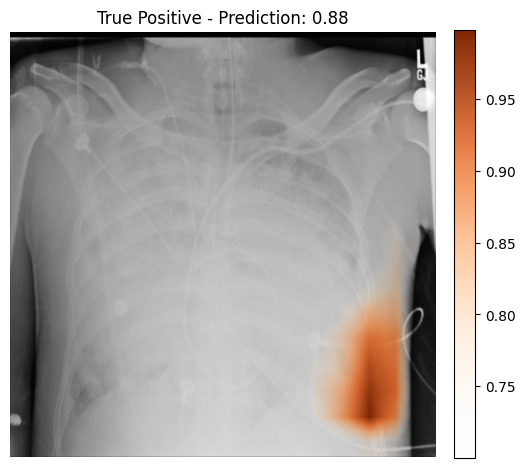

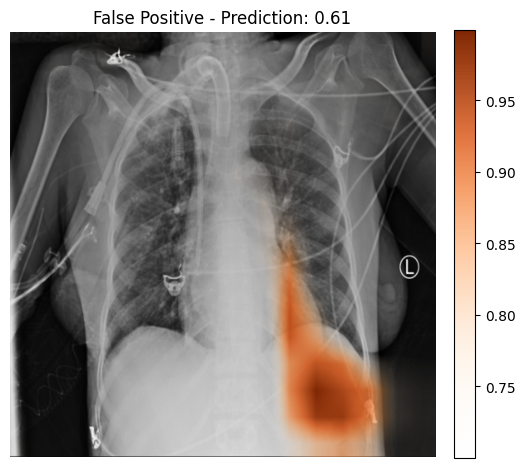

In [231]:
def attention_visualization(model, y_true, y_probs, device):
    tp_indices, fp_indices = pick_interesting_cases(y_true, y_probs, threshold=0.5, num_cases=3)
    target_layer = simple_model.layer4[-1]
    # Example: pick one TP
    image_tensor_tp, _ = val_dataset[tp_indices[0]]
    attr_tp, pred_tp = apply_gradcam(simple_model, image_tensor_tp, target_layer, device)
    show_gradcam_on_image(image_tensor_tp, attr_tp, title=f"True Positive - Prediction: {pred_tp:.2f}")
    
    # Example: pick one 
    image_tensor_fp, _ = val_dataset[fp_indices[0]]
    attr_fp, pred_fp = apply_gradcam(simple_model, image_tensor_fp, target_layer, device)
    show_gradcam_on_image(image_tensor_fp, attr_fp, title=f"False Positive - Prediction: {pred_fp:.2f}")

In [99]:
!pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 105.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 103.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [100]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchxrayvision as xrv

class LungMaskedXrayDataset(Dataset):
    def __init__(self, image_paths, labels, resize_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.resize_size = resize_size

        # Basic transforms
        self.resize_transform = T.Resize(self.resize_size)
        self.norm_transform = T.Normalize(mean=[0.5], std=[0.5])  # adjust mean/std if different

        # Load the lung segmentation model
        self.lung_segmenter = xrv.models.get_lungs_model()
        self.lung_segmenter.eval()
        for param in self.lung_segmenter.parameters():
            param.requires_grad = False

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image (assuming already tensor [1, H, W])
        img = torch.load(self.image_paths[idx])  # or adjust loading depending on your storage format
        label = self.labels[idx]

        # Resize first
        img = self.resize_transform(img)

        # Prepare for lung segmentation (rescale to [0,1])
        img_for_seg = img.clone()
        img_for_seg = img_for_seg - img_for_seg.min()
        img_for_seg = img_for_seg / (img_for_seg.max() + 1e-8)

        with torch.no_grad():
            lung_mask = self.lung_segmenter(img_for_seg.unsqueeze(0)).squeeze(0)  # [1, H, W] -> [H, W]

        # Threshold lung mask (optional: make binary, e.g., >0.5)
        lung_mask = (lung_mask > 0.5).float()

        # Apply lung mask
        img = img * lung_mask.unsqueeze(0)  # [1, H, W] * [1, H, W]

        # Normalize afterwards
        img = self.norm_transform(img)

        return img, label

In [101]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_lung_masking(dataset, n=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Turn off gradients
    with torch.no_grad():
        for i in range(n):
            ax = axes[i // 3, i % 3]

            img, label = dataset[i]
            
            # Re-load the original unnormalized resized image
            original_img = torch.load(dataset.image_paths[i])
            original_img = dataset.resize_transform(original_img)

            # Rescale original to [0,1] for visualization
            original_img = original_img - original_img.min()
            original_img = original_img / (original_img.max() + 1e-8)

            # Generate lung mask
            lung_mask = dataset.lung_segmenter(original_img.unsqueeze(0)).squeeze(0)
            lung_mask = (lung_mask > 0.5).float()

            # Plot
            original_img_np = original_img.squeeze(0).cpu().numpy()
            lung_mask_np = lung_mask.cpu().numpy()

            ax.imshow(original_img_np, cmap="gray")
            ax.imshow(lung_mask_np, cmap="jet", alpha=0.4)  # overlay mask semi-transparently
            ax.axis("off")
            ax.set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

In [207]:
def enhance_contrast(img, low_percentile=2, high_percentile=98):
    """Enhance contrast by stretching pixel intensities between given percentiles."""
    p_low = np.percentile(img, low_percentile)
    p_high = np.percentile(img, high_percentile)
    img = (img - p_low) / (p_high - p_low)
    img = np.clip(img, 0, 1)
    img = img * 2048 - 1024
    return img
    
def lung_masking_viewer_side_by_side(dataset, n=9):
    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

    with torch.no_grad():
        for i in range(n):
            #print(f"Processing image {i+1}/{n}")
            idx = i % len(dataset)

            # Load raw DICOM image manually (for true original)
            patient_id = dataset.labels_df['patientId'].unique()[idx]
            dcm_path = os.path.join(dataset.images_dir, f"{patient_id}.dcm")
            dcm_data = pydicom.dcmread(dcm_path)
            
            # Load original DICOM image
            original_img = dcm_data.pixel_array.astype(np.float32)
            contrast_img = enhance_contrast(original_img)
            # Clip extreme values
            original_img = np.clip(original_img, -1024, 1024)

            # Make sure it has 1 channel
            if original_img.ndim == 2:
                original_img = np.expand_dims(original_img, axis=0)  # [1, H, W]
                contrast_img =  np.expand_dims(contrast_img, axis=0)  # [1, H, W]     
            # Now apply transform on NumPy array directly
            original_img = dataset.transform(original_img)  # Apply center crop + resize
            contrast_img = dataset.transform(contrast_img)  # Apply center crop + resize
            # Then convert to tensor
            original_img_tensor = torch.tensor(original_img).unsqueeze(0)
            contrast_img_tensor = torch.tensor(contrast_img).unsqueeze(0)
            #seg_outputs = dataset.lung_segmenter(original_img_tensor)  # [1, 14, H, W]
            seg_outputs = dataset.lung_segmenter(contrast_img_tensor)  # [1, 14, H, W]
            seg_outputs = torch.sigmoid(seg_outputs)
            right_lung = seg_outputs[0, 5, :, :]
            left_lung = seg_outputs[0, 4, :, :]
            lung_mask = (right_lung + left_lung)>0.3
            lung_mask = lung_mask.float()

            #print(f"Lung mask stats: min={lung_mask.min().item()}, max={lung_mask.max().item()}, mean={lung_mask.mean().item()}")

            # Plot original
            axes[0, i].imshow(original_img.squeeze(0), cmap="gray")
            axes[0, i].axis("off")
            axes[0, i].set_title(f"Original\nPatient: {patient_id}")

            # Plot masked
            axes[1, i].imshow(original_img.squeeze(0), cmap="gray")
            axes[1, i].imshow(lung_mask.cpu(), cmap="jet", alpha=0.7)  # Overlay lung mask
            axes[1, i].axis("off")
            axes[1, i].set_title(f"Masked\nPatient: {patient_id}")

    plt.tight_layout()
    plt.show()


In [173]:
# Define your resizing transform
resize_transform = T.Resize((512,512))  # or whatever size you want

import os

# Correct path!
images_dir = "datasets/rsna-pneumonia/stage_2_train_images"

# Define your resizing transform
resize_transform = T.Resize((512, 512))  # or whatever size you want

# Get all available DICOM filenames (without .dcm ending)
available_files = set([f.split(".")[0] for f in os.listdir(images_dir) if f.endswith(".dcm")])

# Filter your labels dataframe
filtered_labels_df = df_labels[df_labels['patientId'].isin(available_files)]

# Create the dataset
dataset2 = PneumoniaDataset(
    labels_df=filtered_labels_df,
    images_dir=images_dir,
   # transform=resize_transform,
    apply_lung_mask=True
)

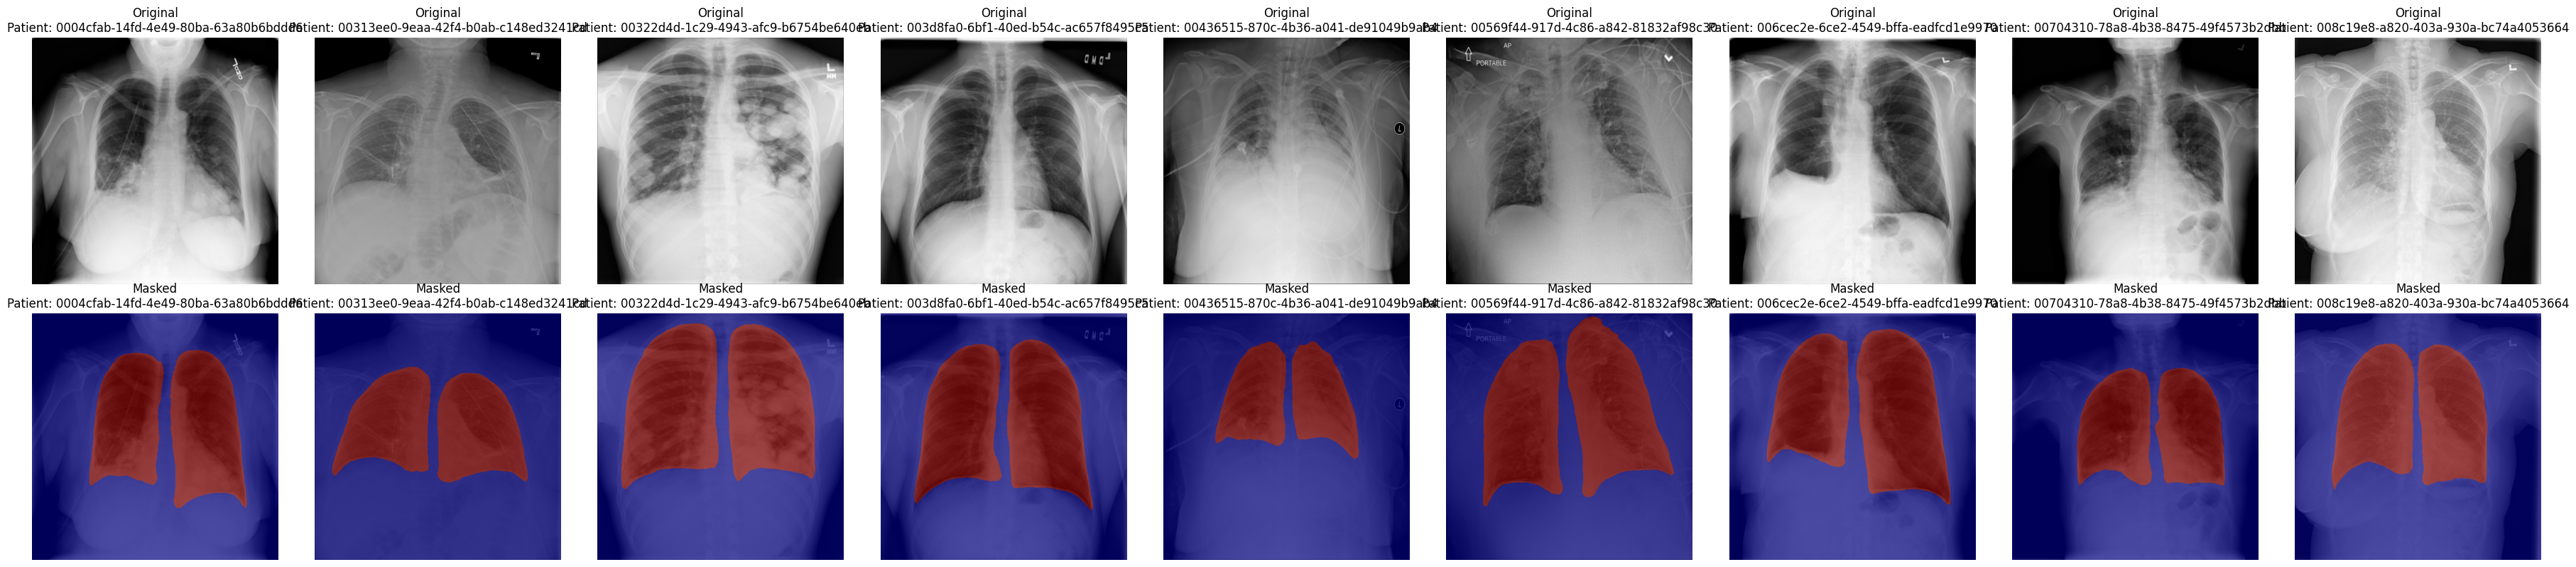

In [209]:
lung_masking_viewer_side_by_side(dataset2)

In [217]:
# Quick check on the data
sample_batch = next(iter(train_loader_masked))
print(f"Sample batch type: {type(sample_batch)}")

images, labels = sample_batch
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Sample batch type: <class 'list'>
Images shape: torch.Size([4, 1, 512, 512])
Labels shape: torch.Size([4])


In [247]:
import copy
def enhance_contrast(img, low_percentile=2, high_percentile=98):
    """Enhance contrast of the image for better lung segmentation."""
    p_low = np.percentile(img, low_percentile)
    p_high = np.percentile(img, high_percentile)
    img = (img - p_low) / (p_high - p_low)
    img = np.clip(img, 0, 1)
    img = img * 2048 - 1024
    return img

def create_masked_dataset(original_images_dir, masked_pt_dir, masked_dcm_dir, labels_file):
    lung_segmenter = xrv.baseline_models.chestx_det.PSPNet()
    lung_segmenter.eval()

    os.makedirs(masked_pt_dir, exist_ok=True)
    os.makedirs(masked_dcm_dir, exist_ok=True)

    df_labels = pd.read_csv(labels_file)

    resize_transform = T.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(512)
    ])

    for patient_id in tqdm(df_labels['patientId'].unique(), desc="Masking and Saving"):
        dcm_path = os.path.join(original_images_dir, f"{patient_id}.dcm")
        if not os.path.exists(dcm_path):
            continue

        # --- Load original DICOM ---
        original_dcm = pydicom.dcmread(dcm_path)
        img = original_dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -1024, 1024)

        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)  # [1, H, W]

        img_tensor = torch.from_numpy(img).float()

        # --- Create contrast-enhanced copy for segmentation ---
        img_contrast = enhance_contrast(img.squeeze(0))  # remove channel temporarily
        img_contrast = np.expand_dims(img_contrast, axis=0)  # [1, H, W]
        img_contrast_tensor = torch.from_numpy(img_contrast).float()

        img_contrast_tensor = resize_transform(img_contrast_tensor.numpy())
        img_contrast_tensor = torch.from_numpy(img_contrast_tensor).float()

        img_tensor = resize_transform(img_tensor.numpy())
        img_tensor = torch.from_numpy(img_tensor).float()

        img_contrast_input = img_contrast_tensor.unsqueeze(0)  # [1, 1, 512, 512]

        with torch.no_grad():
            seg_outputs = lung_segmenter(img_contrast_input)
            seg_outputs = torch.sigmoid(seg_outputs)

            right_lung = seg_outputs[0, 5, :, :]
            left_lung = seg_outputs[0, 4, :, :]
            lung_mask = (right_lung + left_lung).clamp(0, 1)
            lung_mask = (lung_mask > 0.05).float()

        # --- Apply lung mask ---
        masked_img = img_tensor * lung_mask.unsqueeze(0)

        # --- Save .pt version ---
        save_pt_path = os.path.join(masked_pt_dir, f"{patient_id}.pt")
        torch.save(masked_img, save_pt_path)

        # --- Save masked DICOM version ---
        masked_img_np = masked_img.squeeze(0).numpy()  # [512, 512]
        masked_img_np = (masked_img_np * 2048) - 1024  # Scale back
        masked_img_np = masked_img_np.astype(np.int16)

        masked_dcm = copy.deepcopy(original_dcm)

        # Replace pixel data
        masked_dcm.PixelData = masked_img_np.tobytes()

        # Update Rows and Columns
        masked_dcm.Rows, masked_dcm.Columns = masked_img_np.shape

        # Update Series Description to mark masked
        masked_dcm.SeriesDescription = "Masked Lung Image (Auto)"

        # Erase UIDs
        masked_dcm.SeriesInstanceUID = None
        masked_dcm.SOPInstanceUID = None
        masked_dcm.StudyInstanceUID = None  # Optional — depends if you want Study UID blanked too

        # (Optional) ConversionType: mark as Workstation (WSD)
        masked_dcm.ConversionType = "WSD"

        # --- Tell DICOM it is now uncompressed ---
        masked_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
        
        # Save masked DICOM
        save_dcm_path = os.path.join(masked_dcm_dir, f"{patient_id}_masked.dcm")
        masked_dcm.save_as(save_dcm_path)

In [248]:
 # Folder paths
original_images_dir = "datasets/rsna-pneumonia/stage_2_train_images"
pt_masked_images_dir = "datasets/rsna-pneumonia/stage_2_train_pt_images_masked"
dicom_masked_images_dir = "datasets/rsna-pneumonia/stage_2_train_dicom_images_masked"
labels_path = 'datasets/rsna-pneumonia/stage_2_train_labels.csv'

create_masked_dataset(original_images_dir, pt_masked_images_dir, dicom_masked_images_dir, labels_path)

Masking and Saving: 100%|██████████| 26684/26684 [4:21:10<00:00,  1.70it/s]  


In [249]:
def find_bad_masked_images(pt_dir, dcm_dir, threshold=0.05, visualize=True, visualize_n=9):
    """
    pt_dir: directory with masked .pt files
    dcm_dir: directory with masked .dcm files
    threshold: minimum % of nonzero pixels to accept
    visualize: whether to show a grid of flagged images
    visualize_n: how many images to show if visualize=True
    """

    bad_images = []
    pt_files = [f for f in os.listdir(pt_dir) if f.endswith('.pt')]

    print(f"🔎 Checking {len(pt_files)} images...")
    for pt_file in tqdm(pt_files):
        pt_path = os.path.join(pt_dir, pt_file)
        img = torch.load(pt_path)  # Shape [1, H, W]
        
        nonzero_count = (img > 0).sum().item()
        total_pixels = img.numel()
        nonzero_ratio = nonzero_count / total_pixels

        if nonzero_ratio < threshold:
            bad_images.append(pt_file.split(".")[0])  # save only patient_id (without extension)

    print(f"\n⚡ Found {len(bad_images)} bad images (below {threshold*100:.1f}% nonzero pixels).")

    # Optional visualization
    if visualize and len(bad_images) > 0:
        n = min(len(bad_images), visualize_n)
        fig, axes = plt.subplots(1, n, figsize=(15, 5))
        for i in range(n):
            pt_path = os.path.join(pt_dir, f"{bad_images[i]}.pt")
            img = torch.load(pt_path).squeeze(0).cpu().numpy()

            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(bad_images[i])
        plt.show()

    # Ask user whether to delete
    if len(bad_images) > 0:
        decision = input(f"❓ Delete all {len(bad_images)} bad images from BOTH pt and dcm? (yes/no): ")
        if decision.lower() == "yes":
            for patient_id in bad_images:
                pt_path = os.path.join(pt_dir, f"{patient_id}.pt")
                dcm_path = os.path.join(dcm_dir, f"{patient_id}_masked.dcm")
                try:
                    os.remove(pt_path)
                    os.remove(dcm_path)
                    print(f"🗑️ Deleted {patient_id}")
                except Exception as e:
                    print(f"⚠️ Failed to delete {patient_id}: {e}")
            print("✅ Finished deleting bad images.")
        else:
            print("❎ No files deleted.")

    return bad_images



In [250]:
#Try to identify images with bad lung-segmentation by looking at images with very few pixels with a value larger
# than 0 (which is the mask_value)

pt_masked_images_dir = "datasets/rsna-pneumonia/stage_2_train_pt_images_masked"
dicom_masked_images_dir = "datasets/rsna-pneumonia/stage_2_train_dicom_images_masked"

find_bad_masked_images(pt_masked_images_dir, dicom_masked_images_dir)




🔎 Checking 26684 images...


100%|██████████| 26684/26684 [13:22<00:00, 33.27it/s]



⚡ Found 1 bad images (below 5.0% nonzero pixels).


❓ Delete all 1 bad images from BOTH pt and dcm? (yes/no):  yes


🗑️ Deleted 66bcb6f8-946f-4f66-8d18-06f17b01d3cd
✅ Finished deleting bad images.


['66bcb6f8-946f-4f66-8d18-06f17b01d3cd']

In [275]:
# 1. List all available masked DICOM filenames (without _masked.dcm ending)
available_patient_ids = set([
    f.replace("_masked.dcm", "") for f in os.listdir('datasets/rsna-pneumonia/stage_2_train_images_masked_dcm_fixed')
    if f.endswith("_masked.dcm")
])

# 2. Filter your labels dataframe
df_labels = df_labels[df_labels['patientId'].isin(available_patient_ids)]

print(f"✅ Filtered labels: {len(df_labels)} remaining")

✅ Filtered labels: 30226 remaining


In [278]:

BATCH_SIZE = 4
resize_transform = transforms.Compose([
                   transforms.Resize((512,512)),  # ResNet is usually trained on 224x224
])
masked_dir = "datasets/rsna-pneumonia/stage_2_train_images_masked_dcm_fixed"
train_dataset_masked = PneumoniaDataset(train_df, masked_dir, transform = resize_transform, )
val_dataset_masked = PneumoniaDataset(val_df, masked_dir, transform = resize_transform)

train_loader_masked = DataLoader(train_dataset_masked, batch_size=BATCH_SIZE, shuffle=True)
val_loader_masked = DataLoader(val_dataset_masked, batch_size=BATCH_SIZE, shuffle=False)

model_masked = simple_model_func(device)



Using device: cuda


Training Batches: 100%|██████████| 5337/5337 [07:02<00:00, 12.63it/s]


Epoch 1/5 - Train Loss: 0.9988 - Train Acc: 0.7784 - Val Acc: 0.7845


Training Batches: 100%|██████████| 5337/5337 [05:25<00:00, 16.40it/s]


Epoch 2/5 - Train Loss: 0.9215 - Train Acc: 0.6956 - Val Acc: 0.7056


Training Batches: 100%|██████████| 5337/5337 [05:07<00:00, 17.34it/s]


Epoch 3/5 - Train Loss: 0.8842 - Train Acc: 0.7065 - Val Acc: 0.7212


Training Batches: 100%|██████████| 5337/5337 [05:03<00:00, 17.58it/s]


Epoch 4/5 - Train Loss: 0.8692 - Train Acc: 0.7171 - Val Acc: 0.7261


Training Batches: 100%|██████████| 5337/5337 [05:02<00:00, 17.67it/s]


Epoch 5/5 - Train Loss: 0.8479 - Train Acc: 0.8033 - Val Acc: 0.8078
✅ Model saved as simple_pneumonia_detector.pth


In [ ]:
main(train_loader_masked, val_loader_masked, model_masked)

Using device: cuda


Training Batches: 100%|██████████| 5337/5337 [05:33<00:00, 16.02it/s]


Epoch 1/5 - Train Loss: 0.8726 - Train Acc: 0.7435 - Val Acc: 0.7499


Training Batches:  29%|██▉       | 1550/5337 [01:33<03:53, 16.20it/s]

In [ ]:

def inspect_masked_image(pt_dir, patient_id=None):
    """
    Load and visualize one masked image from pt_dir.

    Args:
        pt_dir (str): Directory where masked .pt files are stored.
        patient_id (str): Optional. If None, will pick a random .pt file.
    """

    # List all .pt files
    pt_files = [f for f in os.listdir(pt_dir) if f.endswith('.dcm')]

    if not pt_files:
        print("❌ No .dcm files found in directory!")
        return

    # Pick patient
    if patient_id is None:
        chosen_file = pt_files[0]  # Just pick the first one
    else:
        chosen_file = f"{patient_id}.dcm"
        if chosen_file not in pt_files:
            print(f"❌ Patient ID {patient_id} not found in {pt_dir}")
            return

    # Load image
    img = torch.load(os.path.join(pt_dir, chosen_file))

    print(f"✅ Loaded image: {chosen_file}")
    print(f"Shape: {img.shape}")
    print(f"Min: {img.min().item():.2f}, Max: {img.max().item():.2f}, Mean: {img.mean().item():.2f}")

    # If 2 channels accidentally, show both channels separately
    if img.shape[0] == 2:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img[0].cpu().numpy(), cmap="gray")
        axs[0].set_title("Channel 0")
        axs[0].axis("off")

        axs[1].imshow(img[1].cpu().numpy(), cmap="gray")
        axs[1].set_title("Channel 1")
        axs[1].axis("off")

        plt.show()
    else:
        plt.imshow(img.squeeze(0).cpu().numpy(), cmap="gray")
        plt.title(f"Masked Image: {chosen_file}")
        plt.axis("off")
        plt.show()

# Example usage:

pt_dir = "datasets/rsna-pneumonia/stage_2_train_dicom_images_masked"

# To inspect a specific patient:
# inspect_masked_image(pt_dir, patient_id="0004cfab-14fd-4e49-80ba-63a80b6bddd6")

# Or just grab the first available masked image:
inspect_masked_image(pt_dir)

In [262]:
def regenerate_dicom_from_pt_careful(pt_dir, original_dicom_dir, new_dicom_dir):
    """
    Use clean .pt files and original DICOMs to regenerate masked DICOMs,
    keeping all non-UID metadata intact.
    """

    os.makedirs(new_dicom_dir, exist_ok=True)

    pt_files = [f for f in os.listdir(pt_dir) if f.endswith(".pt")]
    print(f"♻️ Regenerating {len(pt_files)} masked DICOMs (careful mode)...")

    for pt_file in tqdm(pt_files):
        patient_id = pt_file.replace(".pt", "")

        pt_path = os.path.join(pt_dir, pt_file)
        orig_dcm_path = os.path.join(original_dicom_dir, f"{patient_id}.dcm")

        if not os.path.exists(orig_dcm_path):
            print(f"⚠️ Original DICOM missing for {patient_id}, skipping...")
            continue

        # Load clean masked image
        masked_img = torch.load(pt_path)  # [1, H, W]
        masked_img_np = masked_img.squeeze(0).cpu().numpy()  # [H, W]

        # Rescale back if necessary (assuming you normalized earlier)
        masked_img_np = (masked_img_np * 2048) - 1024
        masked_img_np = masked_img_np.astype(np.int16)

        # Load original DICOM (for metadata)
        orig_dcm = pydicom.dcmread(orig_dcm_path)

        # --- Carefully modify ---
        # Replace PixelData
        orig_dcm.PixelData = masked_img_np.tobytes()
        orig_dcm.Rows, orig_dcm.Columns = masked_img_np.shape

        # Overwrite TransferSyntax to ExplicitVRLittleEndian
        orig_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

        # Erase UIDs properly (optional)
        if "SOPInstanceUID" in orig_dcm:
            orig_dcm.SOPInstanceUID = pydicom.uid.generate_uid()
        if "SeriesInstanceUID" in orig_dcm:
            orig_dcm.SeriesInstanceUID = pydicom.uid.generate_uid()
        if "StudyInstanceUID" in orig_dcm:
            # If you want to keep StudyInstanceUID, comment next line
            orig_dcm.StudyInstanceUID = pydicom.uid.generate_uid()

        # Optional: mark SeriesDescription so you remember it's masked
        if "SeriesDescription" in orig_dcm:
            orig_dcm.SeriesDescription = str(orig_dcm.SeriesDescription) + " (Masked)"

        # Save corrected DICOM
        save_path = os.path.join(new_dicom_dir, f"{patient_id}_masked.dcm")
        orig_dcm.save_as(save_path)

    print("✅ Finished regenerating masked DICOMs!")

# Example usage:
regenerate_dicom_from_pt_careful(
    pt_dir="datasets/rsna-pneumonia/stage_2_train_pt_images_masked",
    original_dicom_dir="datasets/rsna-pneumonia/stage_2_train_images",
    new_dicom_dir="datasets/rsna-pneumonia/stage_2_train_dicom_images_masked_fixed"
)

♻️ Regenerating 26683 masked DICOMs (careful mode)...


100%|██████████| 26683/26683 [28:13<00:00, 15.76it/s]  

✅ Finished regenerating masked DICOMs!


🔧 Loading masked .pt and original DICOM...
Masked lung image shape: (512, 512)
Masked lung image range: min=0.0000, max=221.0738
✅ Saved corrected masked DICOM: datasets/rsna-pneumonia/stage_2_train_images_masked_dcm_test/0004cfab-14fd-4e49-80ba-63a80b6bddd6_masked_fixed.dcm
🔍 Checking saved DICOM...
New DICOM shape: (512, 512)
New DICOM pixel range: min=0, max=221


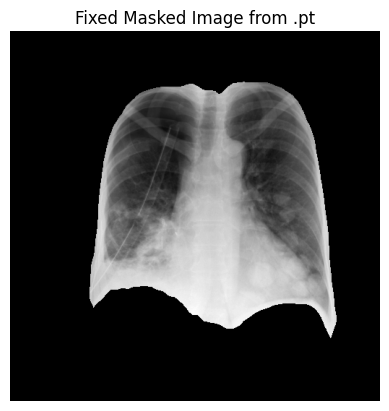

In [269]:
import torch
import pydicom
import numpy as np
import os
import matplotlib.pyplot as plt

def fix_one_masked_image_pt_real(pt_path, original_dicom_path, save_dicom_path):
    """
    Load masked lung image from .pt (already contains real pixel data),
    and save correctly into a new DICOM.
    """

    print("🔧 Loading masked .pt and original DICOM...")

    # 1. Load masked lung image from .pt
    masked_img = torch.load(pt_path)  # [1, H, W]
    masked_img_np = masked_img.squeeze(0).cpu().numpy()  # [H, W]

    print(f"Masked lung image shape: {masked_img_np.shape}")
    print(f"Masked lung image range: min={masked_img_np.min():.4f}, max={masked_img_np.max():.4f}")

    # 2. Rescale pixel values
    if masked_img_np.max() <= 1.5:  # Assume normalized [0,1]
        print("📈 Rescaling normalized image...")
        masked_img_np = (masked_img_np * 4095)  # to 12-bit range

    masked_img_np = np.clip(masked_img_np, 0, 4095)  # Just to be safe
    masked_img_np = masked_img_np.astype(np.uint16)

    # 3. Load original DICOM (only for header metadata)
    orig_dcm = pydicom.dcmread(original_dicom_path)

    # 4. Replace PixelData
    orig_dcm.PixelData = masked_img_np.tobytes()
    orig_dcm.Rows, orig_dcm.Columns = masked_img_np.shape

    # 5. Fix important DICOM tags
    orig_dcm.BitsAllocated = 16
    orig_dcm.BitsStored = 12  # or 16 if you want full range
    orig_dcm.HighBit = orig_dcm.BitsStored - 1
    orig_dcm.PixelRepresentation = 0  # unsigned integers

    orig_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    # 6. Save new masked DICOM
    orig_dcm.save_as(save_dicom_path)

    print(f"✅ Saved corrected masked DICOM: {save_dicom_path}")

    # --- Optional: visualize ---
    print("🔍 Checking saved DICOM...")
    new_dcm = pydicom.dcmread(save_dicom_path)
    new_img = new_dcm.pixel_array

    print(f"New DICOM shape: {new_img.shape}")
    print(f"New DICOM pixel range: min={new_img.min()}, max={new_img.max()}")

    plt.imshow(new_img, cmap="gray")
    plt.title("Fixed Masked Image from .pt")
    plt.axis("off")
    plt.show()

# -----------------------------------------------
# ✏️ Example usage:

patient_id = "0004cfab-14fd-4e49-80ba-63a80b6bddd6"

pt_path = f"datasets/rsna-pneumonia/stage_2_train_pt_images_masked/{patient_id}.pt"
original_dicom_path = f"datasets/rsna-pneumonia/stage_2_train_images/{patient_id}.dcm"
save_dicom_path = f"datasets/rsna-pneumonia/stage_2_train_images_masked_dcm_test/{patient_id}_masked_fixed.dcm"

os.makedirs(os.path.dirname(save_dicom_path), exist_ok=True)

fix_one_masked_image_pt_real(pt_path, original_dicom_path, save_dicom_path)

In [270]:
def regenerate_all_masked_dicoms(pt_dir, original_dicom_dir, save_dicom_dir):
    """
    Batch regenerate masked DICOMs from .pt masked lung images.
    """

    os.makedirs(save_dicom_dir, exist_ok=True)

    pt_files = [f for f in os.listdir(pt_dir) if f.endswith(".pt")]
    print(f"♻️ Regenerating {len(pt_files)} masked DICOMs...")

    for pt_file in tqdm(pt_files):
        # Correct patient ID
        patient_id = pt_file.replace(".pt", "")  # <-- Important!

        pt_path = os.path.join(pt_dir, pt_file)
        orig_dcm_path = os.path.join(original_dicom_dir, f"{patient_id}.dcm")
        save_dcm_path = os.path.join(save_dicom_dir, f"{patient_id}_masked.dcm")

        if not os.path.exists(orig_dcm_path):
            print(f"⚠️ Original DICOM not found for {patient_id}, skipping.")
            continue

        # --- Core masking logic ---
        masked_img = torch.load(pt_path)  # [1, H, W]
        masked_img_np = masked_img.squeeze(0).cpu().numpy()  # [H, W]

        # Rescale if normalized
        if masked_img_np.max() <= 1.5:
            masked_img_np = (masked_img_np * 4095)

        masked_img_np = np.clip(masked_img_np, 0, 4095).astype(np.uint16)

        # Load original DICOM for metadata
        orig_dcm = pydicom.dcmread(orig_dcm_path)

        # Replace PixelData
        orig_dcm.PixelData = masked_img_np.tobytes()
        orig_dcm.Rows, orig_dcm.Columns = masked_img_np.shape

        # Fix DICOM pixel format fields
        orig_dcm.BitsAllocated = 16
        orig_dcm.BitsStored = 12
        orig_dcm.HighBit = orig_dcm.BitsStored - 1
        orig_dcm.PixelRepresentation = 0  # unsigned

        orig_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

        # Save fixed DICOM
        orig_dcm.save_as(save_dcm_path)

    print("✅ All masked DICOMs regenerated!")

# --------------------------------------------------
# ✏️ Example usage:

pt_dir = "datasets/rsna-pneumonia/stage_2_train_pt_images_masked"
original_dicom_dir = "datasets/rsna-pneumonia/stage_2_train_images"
save_dicom_dir = "datasets/rsna-pneumonia/stage_2_train_images_masked_dcm_fixed"

regenerate_all_masked_dicoms(pt_dir, original_dicom_dir, save_dicom_dir)

♻️ Regenerating 26683 masked DICOMs...


100%|██████████| 26683/26683 [30:02<00:00, 14.81it/s]  

✅ All masked DICOMs regenerated!


In [272]:
df_labels.head()


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Testing Batches: 100%|██████████| 1335/1335 [00:35<00:00, 37.48it/s]


[np.float32(-1.9984161), np.float32(-0.89239985), np.float32(0.37490922), np.float32(-3.060911), np.float32(-0.7173947), np.float32(0.46312782), np.float32(-1.0632267), np.float32(-0.22344129), np.float32(-0.9439407), np.float32(-0.55352485)]
Confusion Matrix:
[[3246  851]
 [ 334  906]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9067    0.7923    0.8456      4097
           1     0.5157    0.7306    0.6046      1240

    accuracy                         0.7780      5337
   macro avg     0.7112    0.7615    0.7251      5337
weighted avg     0.8158    0.7780    0.7896      5337



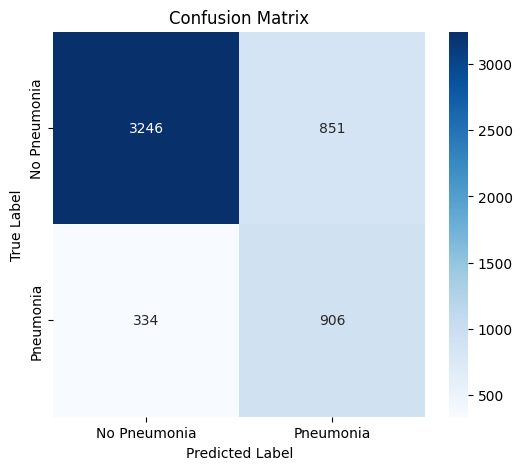

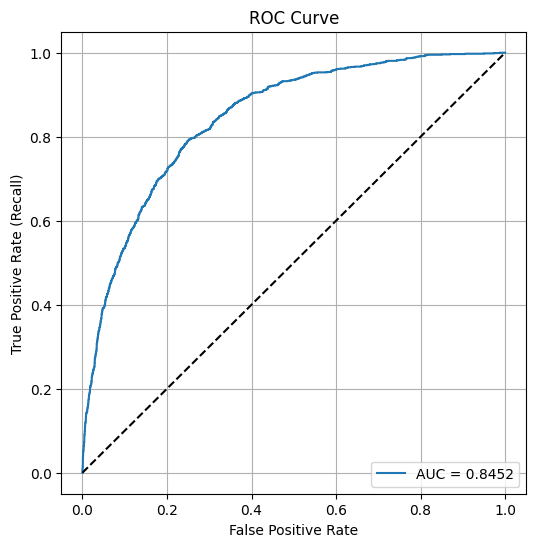

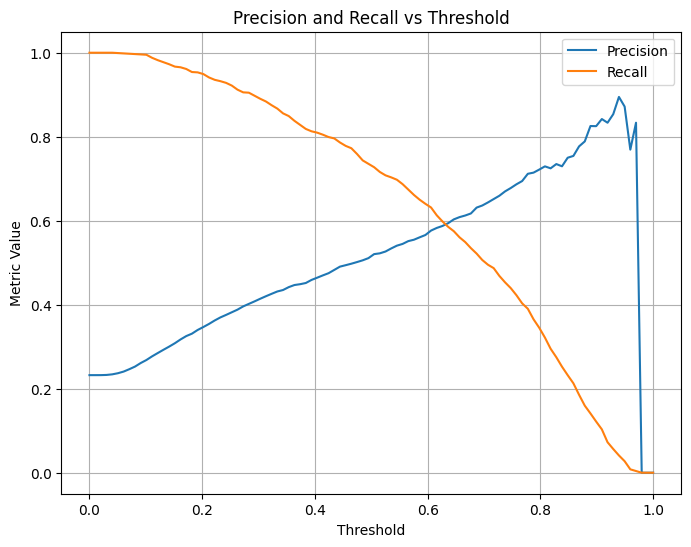

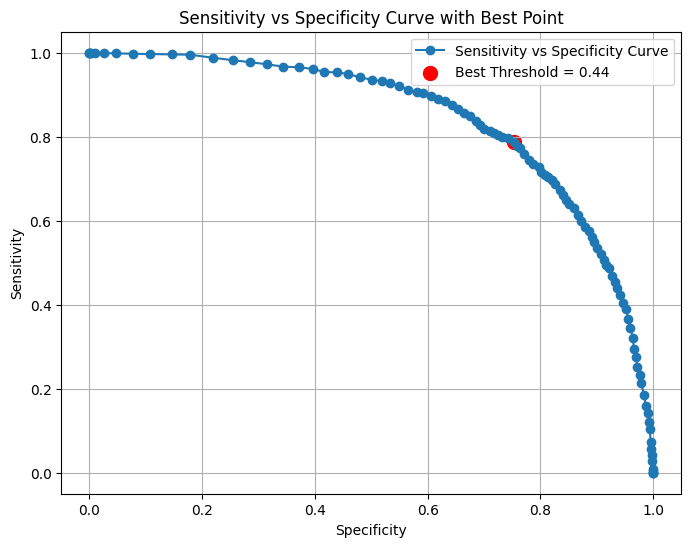

✅ Best Threshold: 0.444
Sensitivity at best threshold: 0.786
Specificity at best threshold: 0.753


In [286]:
y_t, y_p = visualize_metrics(model_masked, val_loader_masked, device)

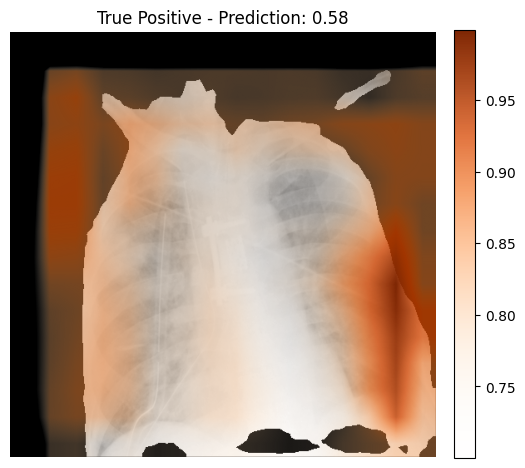

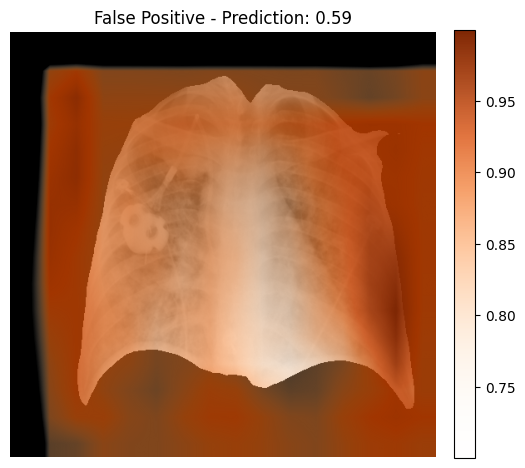

In [297]:
attention_visualization(model_masked, val_dataset_masked, y_t, y_p, device)